# Embeddings

Os embeddings são a representação vetorial de um conjunto de texto. Os embeddings são utilizados pelas LLMs e também em sistemas mais robustos como o RAG para alimentar o contexto da LLM.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dotenv import find_dotenv, load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
_ = load_dotenv(find_dotenv('.env'))

In [7]:
openai = OpenAIEmbeddings(model='text-embedding-ada-002')

## Embeddings

In [3]:
documents = [
    'Este é o primeiro documento. Ele contém informações sobre o projeto',
    'Este é o segundo documento. Ele contém informações sobre o projeto',
    'O terceiro documento oferece uma visão geral dos resultados esperados',
]

In [6]:
# Divide os documentos em chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1_000,
    chunk_overlap=100,
    length_function=len
)

chunks = text_splitter.create_documents(documents)

print('Chunks')
for i, chunk in enumerate(chunks):
    print(f'Chunk: {i}: {chunk.page_content}')

Chunks
Chunk: 0: Este é o primeiro documento. Ele contém informações sobre o projeto
Chunk: 1: Este é o segundo documento. Ele contém informações sobre o projeto
Chunk: 2: O terceiro documento oferece uma visão geral dos resultados esperados


In [8]:
embedded_chunks = openai.embed_documents(
    [chunk.page_content for chunk in chunks]
)

In [9]:
for i, embed in enumerate(embedded_chunks):
    print(f'Embedding {i}: {embed[:5]}')

Embedding 0: [-0.0013508012052625418, 0.008421807549893856, -0.017512314021587372, -0.02262217551469803, 0.0013247787719592452]
Embedding 1: [-0.003566495608538389, 0.009883745573461056, -0.00823329295963049, -0.017946302890777588, 0.002026705536991358]
Embedding 2: [-0.0239573884755373, 0.0007125145639292896, 0.00987283606082201, -0.018887730315327644, 0.027324162423610687]


In [13]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [14]:
similarities = []
for i in range(len(embedded_chunks)):
    for j in range(i+1, len(embedded_chunks)):
        similarity = cosine_similarity(embedded_chunks[i], embedded_chunks[j])
        similarities.append((i, j, similarity))
        print(f'Similaridade entre {i} e {j}: {similarity:.2f}')

Similaridade entre 0 e 1: 0.96
Similaridade entre 0 e 2: 0.85
Similaridade entre 1 e 2: 0.87


## Visualização

In [16]:
embedd_chunks_array = np.array(embedded_chunks)

In [44]:
def similarities_viz(
    chunks,
    similarities,
    reduction_result,
    reduction_instance,
    title
):
    """Cria um gráfico para visualizar a similaridade entre embeddings.

    Args:
        chunks: Documentos
        similarities: Vetor de similaridade
        reduction_result: Resultado do vetor de similaridade pós redução
        reduction_instance: Instância do redutor
        title: Título do gráfico
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(
        reduction_result[:, 0],
        reduction_result[:, 1],
        c='blue',
        edgecolors='k',
        s=50
    )
    for i, chunk in enumerate(chunks):
        plt.text(
            reduction_result[i, 0],
            reduction_result[i, 1],
            f'Chunk {i}',
            fontsize=12
        )
    for (i, j, similarity) in similarities:
        plt.plot(
            [reduction_result[i, 0], reduction_result[j, 0]],
            [reduction_result[i, 1], reduction_result[j, 1]],
            'k--',
            alpha=similarity
        )
        mid_x = (reduction_result[i, 0] + reduction_result[j, 0]) / 2
        mid_y = (reduction_result[i, 1] + reduction_result[j, 1]) / 2
        plt.text(mid_x, mid_y, f'{similarity:.2f}', fontsize=8, color='green')
    plt.title(title)
    try:
        plt.xlabel(
            f'Componente 1: {reduction_instance.explained_variance_ratio_[0]:.2f}'
        )
        plt.ylabel(
            f'Componente 2: {reduction_instance.explained_variance_ratio_[1]:.2f}'
        )
    except Exception:
        plt.xlabel('Componente 1')
        plt.ylabel('Componente 2')
    plt.grid(True)
    plt.show()

### PCA

In [45]:
pca = PCA(n_components=2)

In [46]:
pca_result = pca.fit_transform(embedd_chunks_array)

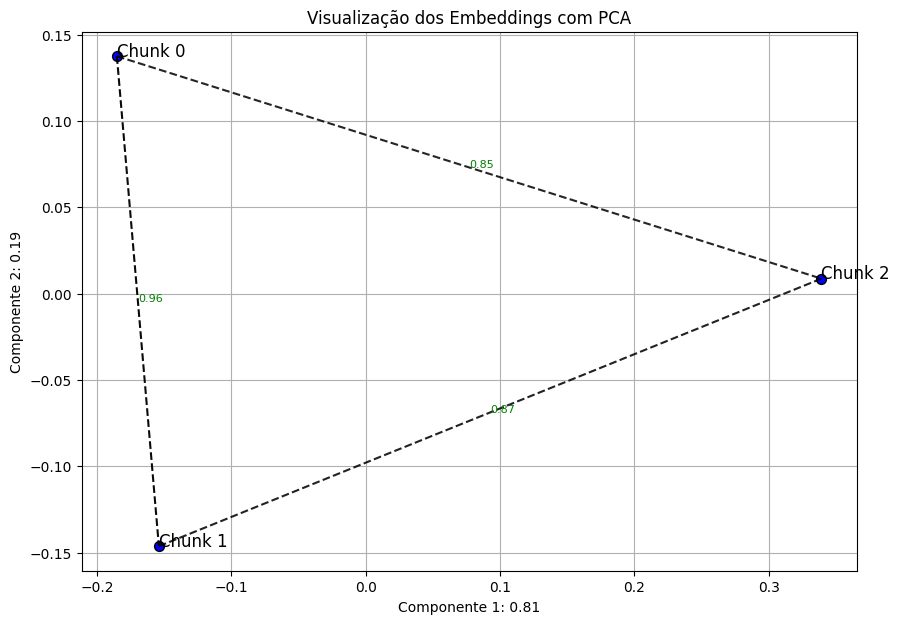

In [47]:
similarities_viz(
    chunks,
    similarities,
    pca_result,
    pca,
    'Visualização dos Embeddings com PCA'
)

### TSNE

In [48]:
tsne = TSNE(n_components=2, perplexity=2, max_iter=300)
tsne_result = tsne.fit_transform(embedd_chunks_array)

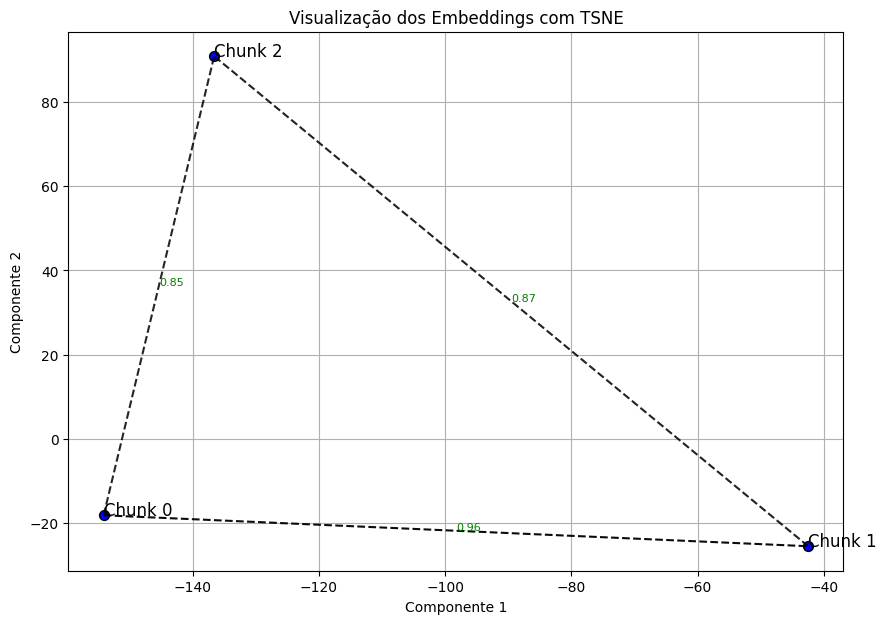

In [49]:
similarities_viz(
    chunks,
    similarities,
    tsne_result,
    tsne,
    'Visualização dos Embeddings com TSNE'
)